In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
#tensorflow.contrib.learn.python.learn.datasets.mnist
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
sess = tf.InteractiveSession()

In [4]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [5]:
# one hidden-layer MLP classfier
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

sess.run(tf.global_variables_initializer())

y = tf.matmul(x,W) + b
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
for i in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))


0.9177


In [9]:
# Convnet softmax classfier

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

x_image = tf.reshape(x, [-1,28,28,1]) # -1 use to flatten x, x_image.shape=(1, 28, 28, 1)

#First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#Densely Connected Layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Readout Layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.06
step 100, training accuracy 0.84
step 200, training accuracy 0.94
step 300, training accuracy 0.92
step 400, training accuracy 0.96
step 500, training accuracy 0.92
step 600, training accuracy 0.92
step 700, training accuracy 0.94
step 800, training accuracy 0.92
step 900, training accuracy 0.96
step 1000, training accuracy 0.98
step 1100, training accuracy 0.98
step 1200, training accuracy 0.96
step 1300, training accuracy 0.96
step 1400, training accuracy 0.96
step 1500, training accuracy 0.96
step 1600, training accuracy 0.98
step 1700, training accuracy 0.98
step 1800, training accuracy 0.96
step 1900, training accuracy 0.98
step 2000, training accuracy 0.96
step 2100, training accuracy 0.98
step 2200, training accuracy 0.94
step 2300, training accuracy 1
step 2400, training accuracy 0.96
step 2500, training accuracy 0.98
step 2600, training accuracy 1
step 2700, training accuracy 0.98
step 2800, training accuracy 0.98
step 2900, training accuracy 0.9

In [31]:
#test_image = pd.read_csv('./MNIST_data/kaggle_test.csv')
batch_size = 1000
assert(test_image.shape[0] % batch_size == 0)
y_pred = []
for i in range(int(test_image.shape[0]/batch_size)):
    y_pred.append(y_conv.eval(feed_dict={x: test_image.values[i*batch_size: (i+1)*batch_size], keep_prob: 1.0}))
y_pred = np.array(y_pred)
y_pred = y_pred.flatten().reshape(-1,10)

In [8]:
y_pred_index = np.argmax(y_pred, axis=1)
image_id = np.arange(y_pred_index.shape[0])
submission = pd.DataFrame({
        "ImageId": image_id+1,
        "Label": y_pred_index
    })
submission.to_csv('./mnist_submission.csv', index=False)

In [28]:
def display_network(A, filename='weights.png'):
    opt_normalize = True
    opt_graycolor = True

    # Rescale
    A = A - np.average(A)

    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    n = np.ceil(np.sqrt(col))
    m = np.ceil(col / n)

    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))

    if not opt_graycolor:
        image *= 0.1

    k = 0
    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue

            clim = np.max(np.abs(A[:, k]))

            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / np.max(np.abs(A))
            k += 1

    plt.imsave(filename, image, cmap="gray")
    
display_network(W1.eval())

/Users/yu/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [27]:
# autoencoder
import random

def sample_images(x):
    patch_size = 8
    num_patches = 1000
    num_images = 100
    image_size = 784

    # Initialize patches with zeros.
    patches = tf.zeros(shape=(num_patches, patch_size * patch_size))

    for i in range(num_patches):
        image_id = random.randint(0, num_images - 1)
        image_x = random.randint(0, image_size - patch_size)
        image_y = random.randint(0, image_size - patch_size)

        img = x[image_id, :]
        pathch = img.reshape()
        patch = img[image_x:image_x + patch_size, image_y:image_y + patch_size].reshape(patch_size * patch_size)
        patches[:, i] = patch

    return patches

def KL_divergence(x, y):
    return x * tf.log(x / y) + (1 - x) * tf.log((1 - x) / (1 - y))

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

x = tf.placeholder(tf.float32, shape=[None, 784])

W1 = weight_variable([784, 400])
b1 = bias_variable([400])
sparsity_param = tf.constant([0.035])
lambda_ = tf.constant(3e-3)
beta = tf.constant([3.0])
W2 = weight_variable([400,784])
b2 = bias_variable([784])


z2 = tf.matmul(x, W1) + b1
a2 = tf.nn.sigmoid(z2)

z3 = tf.matmul(a2, W2) + b2
h = tf.nn.sigmoid(z3)

# Sparsity
#rho_hat = np.sum(a2, axis=1) / m

rho_hat = tf.reduce_mean(a2, axis=0)
rho = tf.tile(sparsity_param, [400])

# # Cost function
# cross_entropy = np.sum((h - data) ** 2) / (2 * m) + \
#     (lambda_ / 2) * (np.sum(W1 ** 2) + np.sum(W2 ** 2)) + \
#     beta * np.sum(KL_divergence(rho, rho_hat))
cross_entropy = tf.reduce_mean(tf.reduce_sum(tf.squared_difference(h, x), axis=1)) \
                     + lambda_ * (tf.reduce_sum(tf.square(W1)) + tf.reduce_sum(tf.square(W2))) \
                     + beta * tf.reduce_sum(KL_divergence(rho, rho_hat))
        
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

sess.run(tf.global_variables_initializer())

for i in range(50000+1):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0]})
    if i%5000 == 0:
        print("step %d, training accuracy %g" %(i, cross_entropy.eval(feed_dict={x: batch[0]})))
    
# correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# print(accuracy.eval(feed_dict={x: mnist.test.images}))

step 0, training cross_entropy 954.018
step 5000, training cross_entropy 62.477
step 10000, training cross_entropy 48.7112
step 15000, training cross_entropy 47.0134
step 20000, training cross_entropy 40.9315
step 25000, training cross_entropy 38.4399
step 30000, training cross_entropy 38.4618
step 35000, training cross_entropy 38.1467
step 40000, training cross_entropy 36.9725
step 45000, training cross_entropy 35.5002
step 50000, training cross_entropy 34.7626


In [30]:
W1.eval()

array([[ -6.12354901e-33,  -1.08152261e-32,   8.20089585e-33, ...,
          6.74875478e-33,   1.43854244e-33,  -2.82618725e-33],
       [  1.26644565e-33,  -3.44727494e-33,  -2.88014924e-33, ...,
          1.61087211e-33,   7.72476921e-33,   1.43465912e-32],
       [  3.99889293e-33,   1.84662650e-33,   4.75688401e-33, ...,
         -1.43480297e-32,   3.83413380e-33,   1.09874052e-32],
       ..., 
       [  2.52706123e-34,   1.68684556e-32,   5.84488668e-33, ...,
         -6.06752568e-33,  -6.19394606e-35,  -3.65532366e-35],
       [  4.81715197e-33,   1.11934899e-32,   3.42503201e-33, ...,
          2.16189850e-33,   3.95860359e-33,   1.19818668e-32],
       [  3.88593159e-33,   1.86840683e-32,  -1.42651720e-32, ...,
          1.56827146e-33,  -8.69671863e-33,  -1.15864136e-32]], dtype=float32)

In [19]:
cross_entropy.eval(feed_dict={x: mnist.train.images})

array([ 34.73509216], dtype=float32)

In [68]:
import scipy.io
image_data = scipy.io.loadmat('./MNIST_data/IMAGES.mat')['IMAGES']

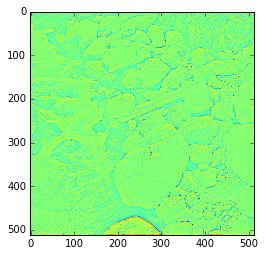

In [73]:
plt.imshow(image_data[:,:,1])

In [4]:
import os
import sys
file_name = 'account.txt'

In [6]:
sys.argv[0]


'/Users/yu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py'